# Temperature Prediction Analysis
This notebook analyzes historical temperature data and tests different prediction algorithms.

In [65]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import os
import pytz

In [66]:
# Initialize InfluxDB client
client = InfluxDBClient(
    url=os.environ['INFLUXDB_URL'],
    token=os.environ['INFLUXDB_TOKEN'],
    org=os.environ['INFLUXDB_ORG']
)

In [67]:
# Add this cell to debug environment variables
print("InfluxDB Settings:")
print(f"URL: {os.environ.get('INFLUXDB_URL', 'Not set')}")
print(f"Bucket: {os.environ.get('INFLUXDB_BUCKET', 'Not set')}")
print(f"Org: {os.environ.get('INFLUXDB_ORG', 'Not set')}")
print("Token available:", bool(os.environ.get('INFLUXDB_TOKEN')))

InfluxDB Settings:
URL: https://us-east-1-1.aws.cloud2.influxdata.com
Bucket: brick-oven
Org: home
Token available: True


In [68]:
def fetch_temperature_data(start_time, end_time, location=None):
    """Fetch temperature data from InfluxDB for the specified time range"""
    query = f'''
    from(bucket: "{os.environ['INFLUXDB_BUCKET']}")
        |> range(start: {start_time}, stop: {end_time})
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    '''
    
    if location:
        query += f'|> filter(fn: (r) => r["location"] == "{location}")'
        
    try:
        result = client.query_api().query_data_frame(query)
        print(f"Query executed: {query}")  # Debug print
        
        if isinstance(result, list):
            if len(result) > 0:
                return result[0]
            else:
                print("Query returned empty list")
                return pd.DataFrame()
        return result
        
    except Exception as e:
        print(f"Error querying InfluxDB: {str(e)}")
        return pd.DataFrame()

In [75]:
# Convert ET to UTC for API call
et_tz = pytz.timezone('America/New_York')
utc_tz = pytz.UTC

# Define times in ET
start_time_et = et_tz.localize(datetime.strptime("2025-05-06T22:00:00", "%Y-%m-%dT%H:%M:%S"))
end_time_et = et_tz.localize(datetime.strptime("2025-05-07T08:00:00", "%Y-%m-%dT%H:%M:%S"))

# Convert to UTC for API call
start_time_utc = start_time_et.astimezone(utc_tz).strftime("%Y-%m-%dT%H:%M:%SZ")
end_time_utc = end_time_et.astimezone(utc_tz).strftime("%Y-%m-%dT%H:%M:%SZ")

print(f"Fetching data between:")
print(f"ET: {start_time_et.strftime('%Y-%m-%dT%H:%M:%S %Z')}")
print(f"UTC: {start_time_utc}")

df = fetch_temperature_data(start_time_utc, end_time_utc)
print(f"\nDataFrame shape: {df.shape}")
print("DataFrame columns:", df.columns.tolist() if not df.empty else "No columns (empty DataFrame)")

# If data is returned, convert timestamps back to ET for display
if not df.empty and '_time' in df.columns:
    df['_time'] = df['_time'].dt.tz_convert(et_tz)

Fetching data between:
ET: 2025-05-06T22:00:00 EDT
UTC: 2025-05-07T02:00:00Z


/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
     |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdlib/influxdata/in

Query executed: 
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    

DataFrame shape: (2907, 10)
DataFrame columns: ['result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'location', 'name']


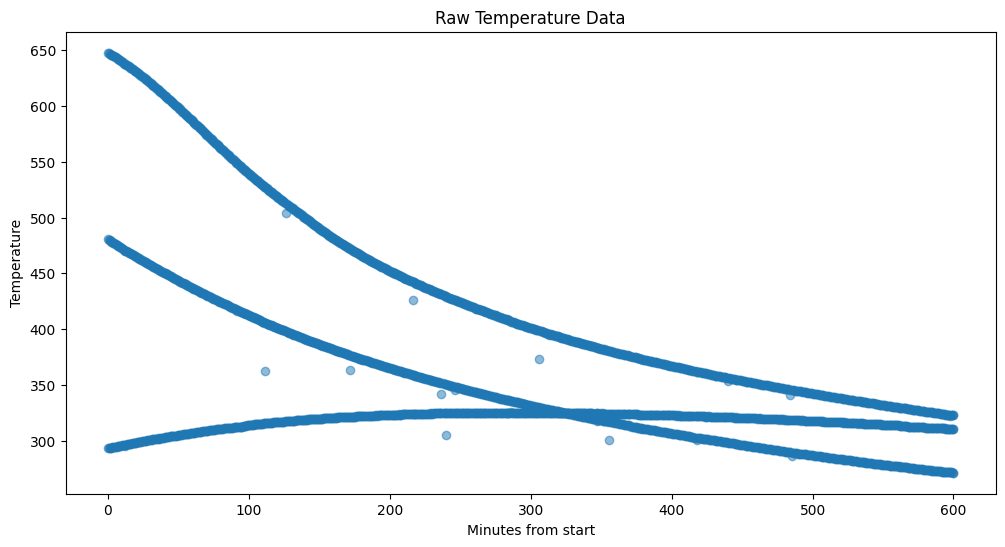

In [76]:


# Convert time to minutes from start
df['minutes'] = (df['_time'] - df['_time'].min()).dt.total_seconds() / 60

# Plot raw data
plt.figure(figsize=(12, 6))
plt.scatter(df['minutes'], df['_value'], alpha=0.5)
plt.xlabel('Minutes from start')
plt.ylabel('Temperature')
plt.title('Raw Temperature Data')
plt.show()

## Test Different Curve Fitting Models

In [77]:
def exp_decay(t, a, b, c):
    return a * np.exp(b * t) + c

def double_exp_decay(t, a1, b1, a2, b2, c):
    return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c

def polynomial(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

models = {
    'Single Exponential': (exp_decay, [df['_value'].max()-df['_value'].min(), -0.01, df['_value'].min()]),
    'Double Exponential': (double_exp_decay, [df['_value'].max()/2, -0.01, df['_value'].max()/2, -0.001, df['_value'].min()]),
    'Polynomial': (polynomial, [0, 0, 0, df['_value'].mean()])
}

In [80]:
def test_prediction_accuracy(data, model_func, p0, window_minutes=60, predict_minutes=30):
    """Test prediction accuracy with error tracking"""
    errors = []
    total_attempts = 0
    successful_fits = 0
    
    for i in range(window_minutes, len(data)-predict_minutes):
        total_attempts += 1
        # Use window_minutes of data to predict
        window = data[i-window_minutes:i]
        
        try:
            # Fit model to window
            popt, _ = curve_fit(model_func, window['minutes'].values, window['_value'].values, p0=p0)
            
            # Predict temperature
            future_time = data['minutes'].values[i + predict_minutes]
            predicted = model_func(future_time, *popt)
            actual = data['_value'].values[i + predict_minutes]
            
            errors.append(abs(predicted - actual))
            successful_fits += 1
            
        except RuntimeError:
            continue
    
    if successful_fits < total_attempts * 0.5:  # Require at least 50% success rate
        return None, None, successful_fits, total_attempts
    
    return np.mean(errors), np.std(errors), successful_fits, total_attempts

def analyze_location(location, start_time_utc, end_time_utc):
    """Analyze temperature data for a specific location"""
    print(f"\n=== Analyzing {location} ===")
    
    # Fetch data for this location
    df = fetch_temperature_data(start_time_utc, end_time_utc, location)
    if df.empty:
        print(f"No data found for {location}")
        return
        
    # Convert timestamps to ET
    df['_time'] = df['_time'].dt.tz_convert(et_tz)
    df['minutes'] = (df['_time'] - df['_time'].min()).dt.total_seconds() / 60
    
    # Plot raw data
    plt.figure(figsize=(12, 6))
    plt.scatter(df['minutes'], df['_value'], alpha=0.5)
    plt.xlabel('Minutes from start')
    plt.ylabel('Temperature (°F)')
    plt.title(f'Raw Temperature Data - {location}')
    plt.show()
    
    # Update models with this location's data
    models = {
        'Single Exponential': (exp_decay, [df['_value'].max()-df['_value'].min(), -0.01, df['_value'].min()]),
        'Double Exponential': (double_exp_decay, [df['_value'].max()/2, -0.01, df['_value'].max()/2, -0.001, df['_value'].min()]),
        'Polynomial': (polynomial, [0, 0, 0, df['_value'].mean()])
    }
    
    # Test each model
    plt.figure(figsize=(15, 10))
    x_data = df['minutes'].values
    y_data = df['_value'].values
    
    for name, (func, p0) in models.items():
        try:
            popt, _ = curve_fit(func, x_data, y_data, p0=p0, maxfev=5000)
            y_pred = func(x_data, *popt)
            
            mse = mean_squared_error(y_data, y_pred)
            r2 = r2_score(y_data, y_pred)
            
            plt.plot(x_data, y_pred, label=f'{name} (MSE={mse:.2f}, R²={r2:.3f})')
            
        except RuntimeError as e:
            print(f"Failed to fit {name}: {e}")
    
    plt.scatter(x_data, y_data, alpha=0.5, label='Actual Data')
    plt.xlabel('Minutes from start')
    plt.ylabel('Temperature (°F)')
    plt.title(f'Model Comparison - {location}')
    plt.legend()
    plt.show()
    
    # Test prediction accuracy with improved reporting
    print("\nPrediction Accuracy:")
    for name, (func, p0) in models.items():
        mean_error, std_error, successes, attempts = test_prediction_accuracy(df, func, p0)
        print(f"{name}:")
        if mean_error is not None:
            print(f"  Mean prediction error: {mean_error:.2f}°F")
            print(f"  Standard deviation: {std_error:.2f}°F")
            print(f"  Success rate: {successes}/{attempts} ({(successes/attempts*100):.1f}%)\n")
        else:
            print(f"  Failed to make reliable predictions (success rate: {successes}/{attempts})\n")


=== Analyzing hearth firebrick ===


/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "hearth firebrick") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - htt

Query executed: 
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "hearth firebrick")


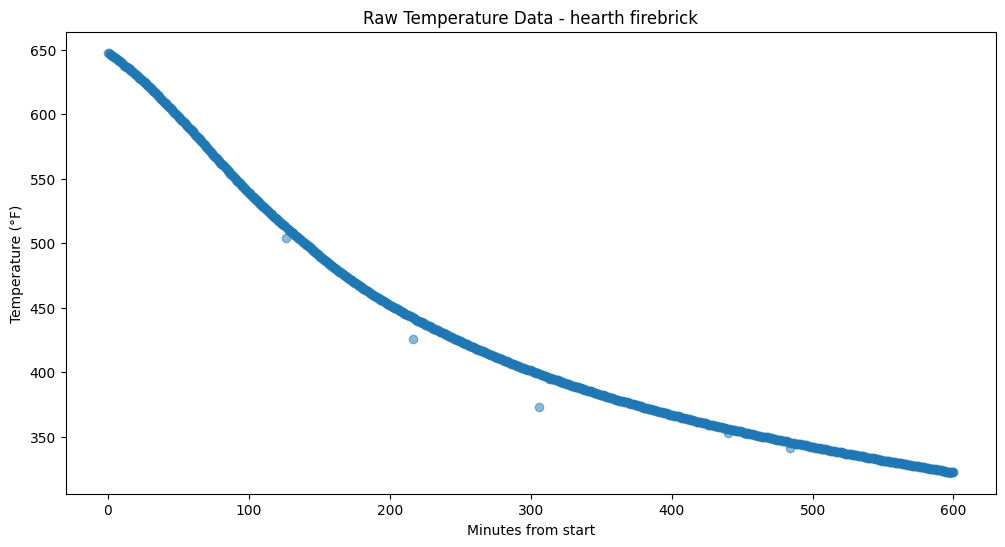

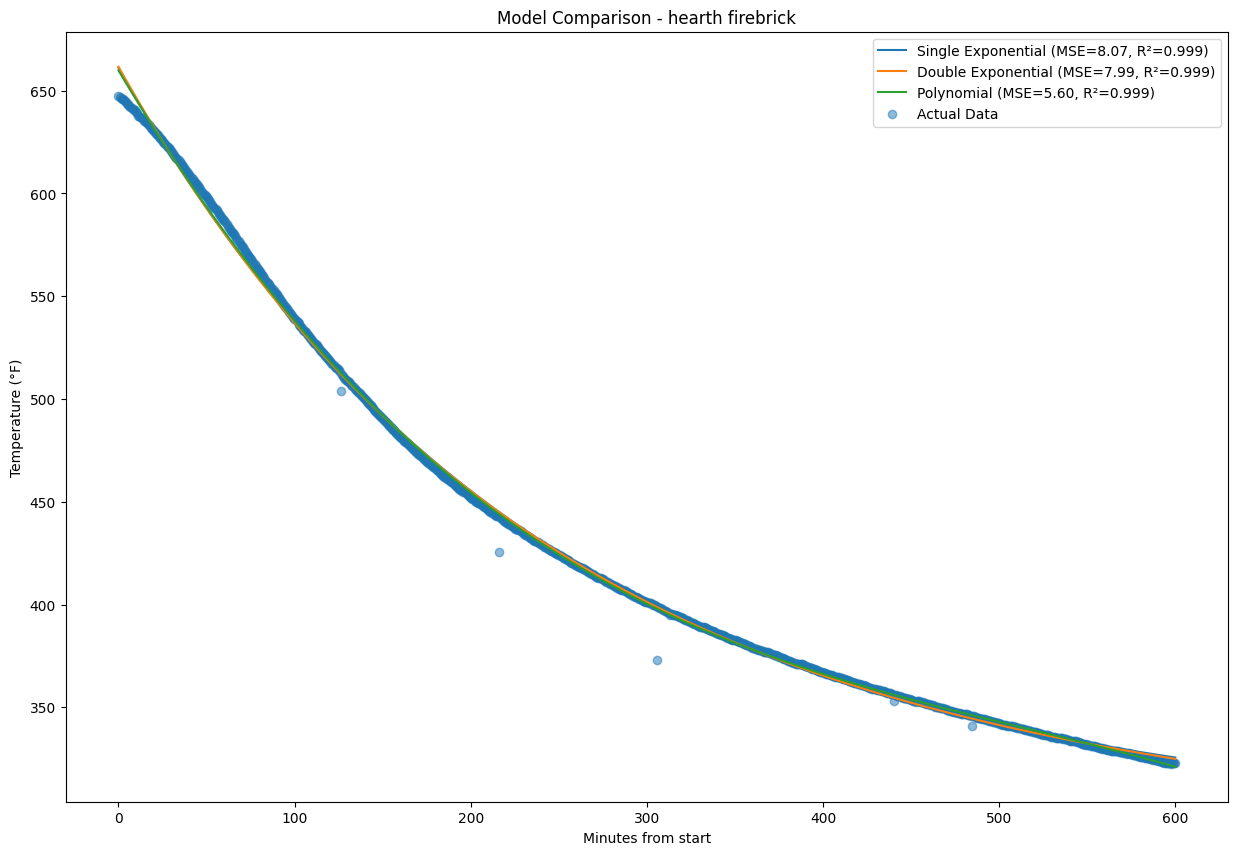


Prediction Accuracy:
Single Exponential:
  Mean prediction error: 0.78°F
  Standard deviation: 1.49°F
  Success rate: 617/879 (70.2%)



/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c


Double Exponential:
  Failed to make reliable predictions (success rate: 274/879)

Polynomial:
  Mean prediction error: 3.64°F
  Standard deviation: 5.77°F
  Success rate: 879/879 (100.0%)


=== Analyzing dome firebrick ===


/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "dome firebrick") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https

Query executed: 
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "dome firebrick")


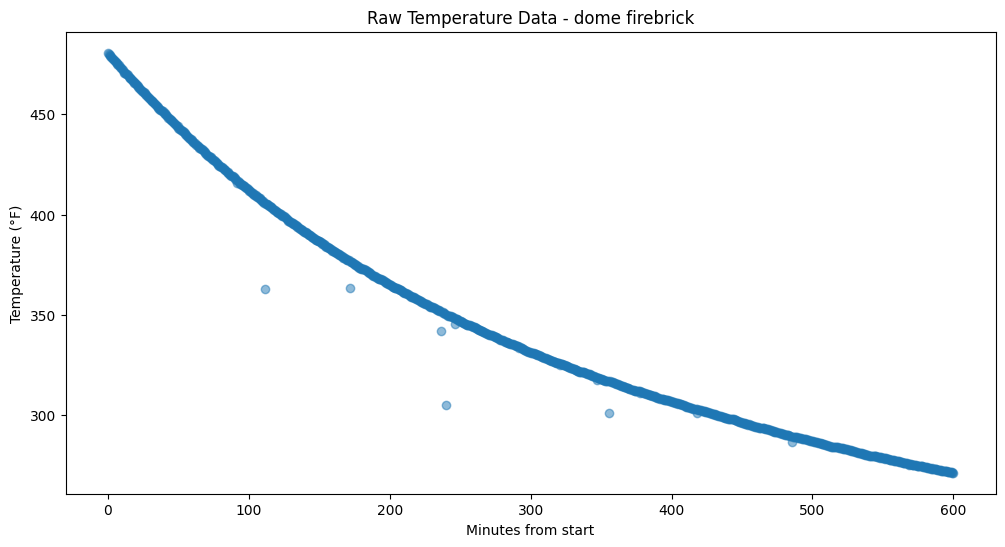

Failed to fit Double Exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.


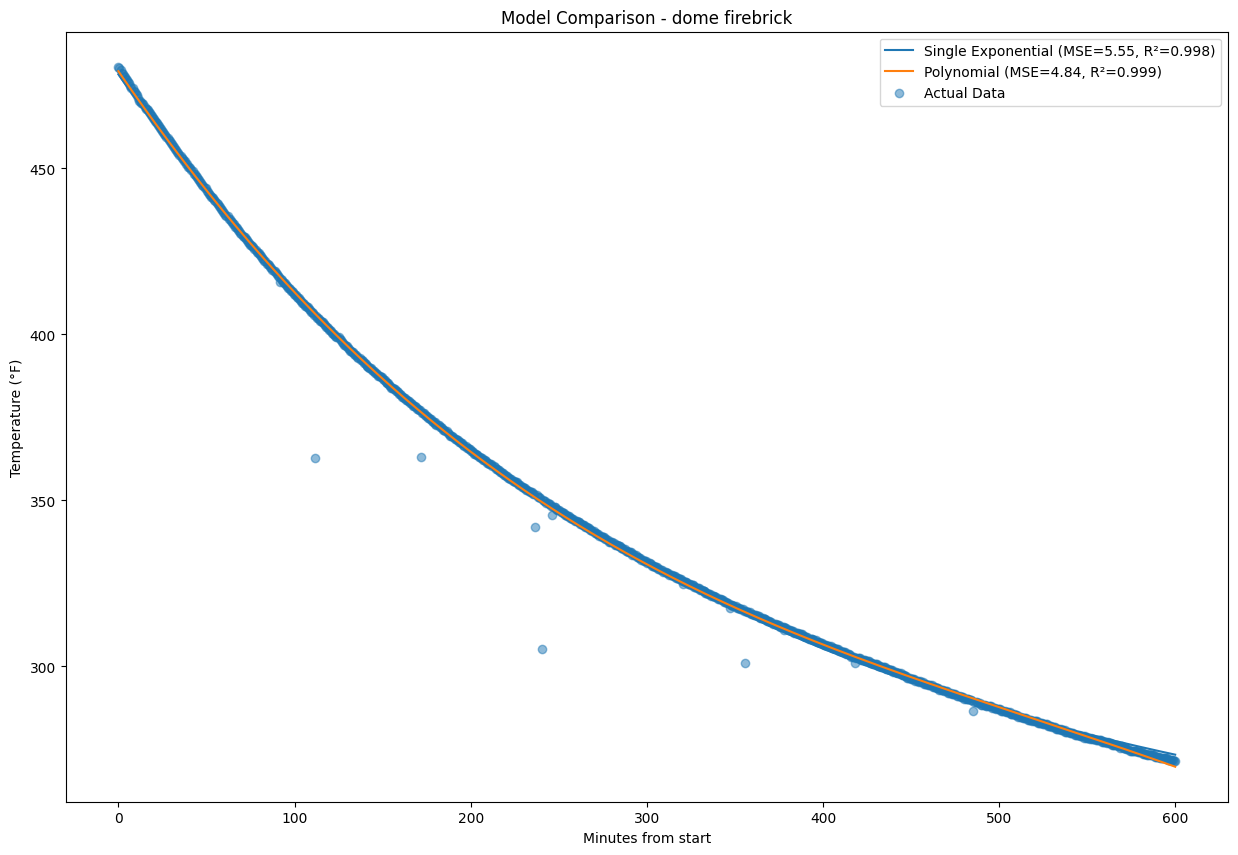


Prediction Accuracy:
Single Exponential:
  Mean prediction error: 1.19°F
  Standard deviation: 3.02°F
  Success rate: 610/879 (69.4%)



/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c
/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Double Exponential:
  Failed to make reliable predictions (success rate: 237/879)

Polynomial:
  Mean prediction error: 6.74°F
  Standard deviation: 12.94°F
  Success rate: 879/879 (100.0%)


=== Analyzing dome cladding ===


/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "dome cladding") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https:

Query executed: 
    from(bucket: "brick-oven")
        |> range(start: 2025-05-07T02:00:00Z, stop: 2025-05-07T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "oven-temp")
        |> filter(fn: (r) => r["_field"] == "temperature")
    |> filter(fn: (r) => r["location"] == "dome cladding")


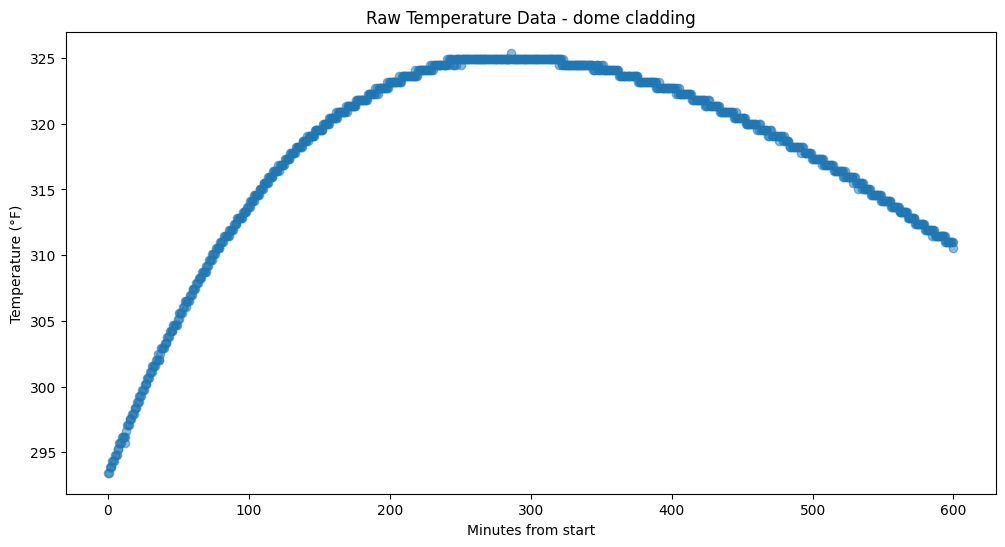

Failed to fit Double Exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.


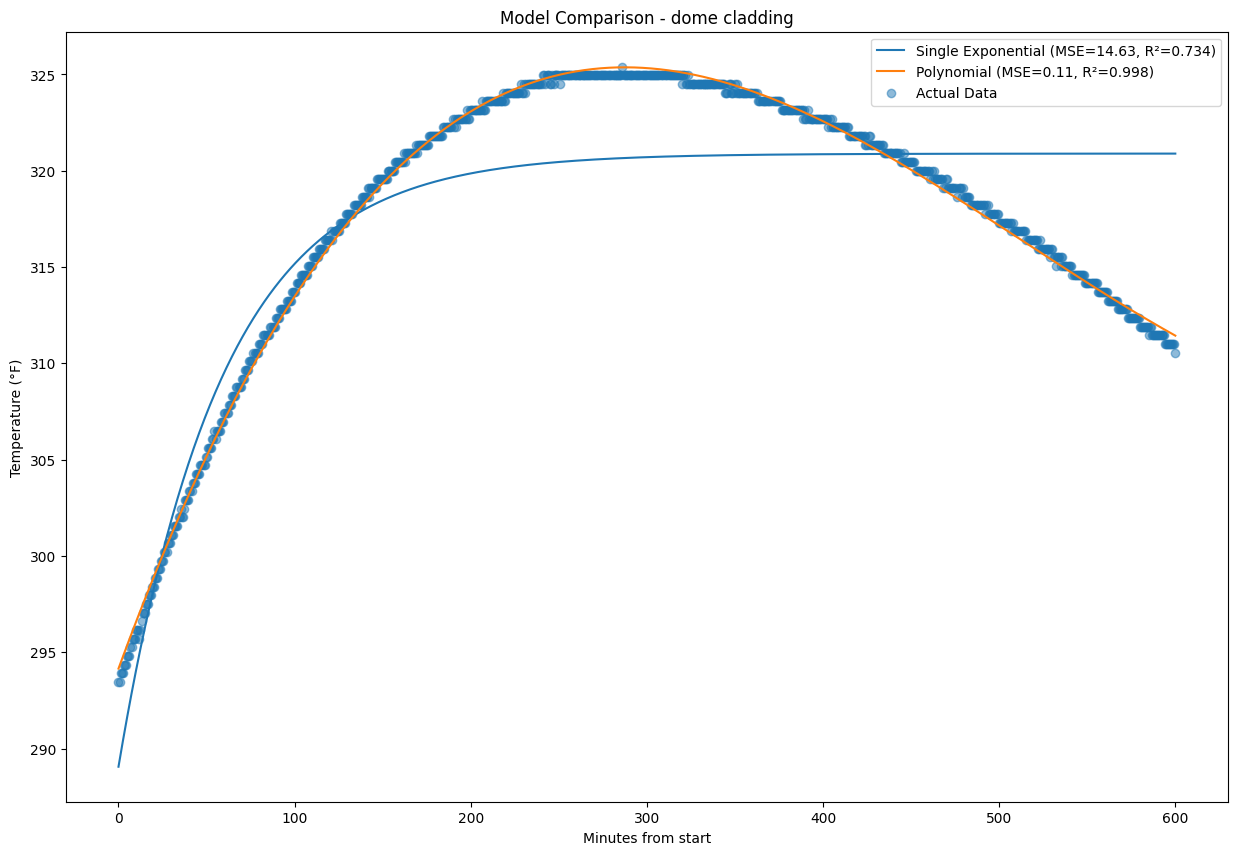


Prediction Accuracy:
Single Exponential:
  Failed to make reliable predictions (success rate: 392/879)



/Users/dleigh/git/dlleigh/temp-logger/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(b * t) + c
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * t) + c
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in exp
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c
/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_89676/3965748619.py:5: RuntimeWarning: overflow encountered in multiply
  return a1 * np.exp(b1 * t) + a2 * np.exp(b2 * t) + c


Double Exponential:
  Failed to make reliable predictions (success rate: 164/879)

Polynomial:
  Mean prediction error: 0.86°F
  Standard deviation: 0.74°F
  Success rate: 879/879 (100.0%)



In [81]:
# Replace the existing analysis cells with this one
locations = ["hearth firebrick", "dome firebrick", "dome cladding"]

for location in locations:
    analyze_location(location, start_time_utc, end_time_utc)